In [1]:
# importing all required pakages and libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from optbinning import OptimalBinning
from sklearn.preprocessing import RobustScaler, StandardScaler,LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
import category_encoders as ce
from sklearn.feature_selection import f_regression, SelectKBest,mutual_info_regression
import xgboost
from sklearn.feature_selection import f_regression, GenericUnivariateSelect
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score,KFold
from scipy.stats import zscore
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
sb.set()

In [2]:
ds = pd.read_excel('Data_Train.xlsx')
ds

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


### EDA and Data-preprocessing

In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


From above info table, we can infer that there are possible missing values.

In [4]:
# defining function to extract categorical date information like month, year, weekday.
def to_date_time(col, df):
    df[col] = pd.to_datetime(df[col], infer_datetime_format = True)
        
    if len(df[col].dt.year.unique()) != 1:
        df[col+'(year)'] = df[col].dt.year
    else:
        pass
    if len(df[col].dt.month.unique()) != 1:
        df[col+'(month)'] = df[col].dt.month
        
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',
            6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df[col+'(month)'] = df[col+'(month)'].map(month_map)
    
    else:
        pass
    if len(df[col].dt.dayofweek.unique()) != 1:
        df[col+'(weekday)'] = df[col].dt.dayofweek
        
        weekday_map = {6:'SUN', 5:'SAT', 4:'FRI', 3:'THU', 2:'WED', 1:'TUE', 0: 'MON'}
        df[col+'(weekday)'] = df[col+'(weekday)'].map(weekday_map)
        
        
    df.drop([col], 1, inplace = True)
    
    return df       

In [5]:
to_date_time('Date_of_Journey', ds)

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Journey(month),Date_of_Journey(weekday)
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,Mar,SUN
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,May,WED
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,Jun,SUN
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,May,SUN
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,Mar,FRI
...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107,Apr,TUE
10679,Air India,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145,Apr,SAT
10680,Jet Airways,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229,Apr,SAT
10681,Vistara,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648,Mar,FRI


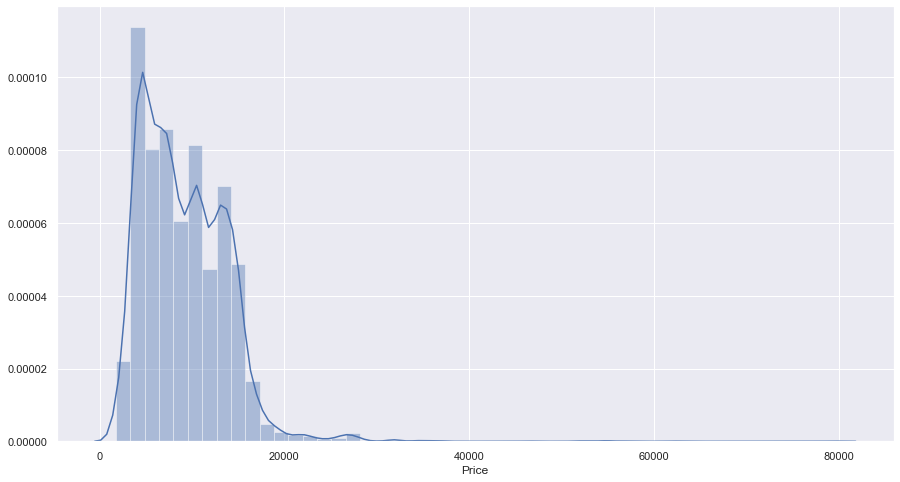

In [6]:
plt.figure(figsize = (15,8))
sb.distplot(ds.Price)
plt.show()

In [7]:
ds.Price.describe()

count    10683.000000
mean      9087.064121
std       4611.359167
min       1759.000000
25%       5277.000000
50%       8372.000000
75%      12373.000000
max      79512.000000
Name: Price, dtype: float64

Here, we see that price of flights is having right skewed distribution with extreme values upto
₹79,512.

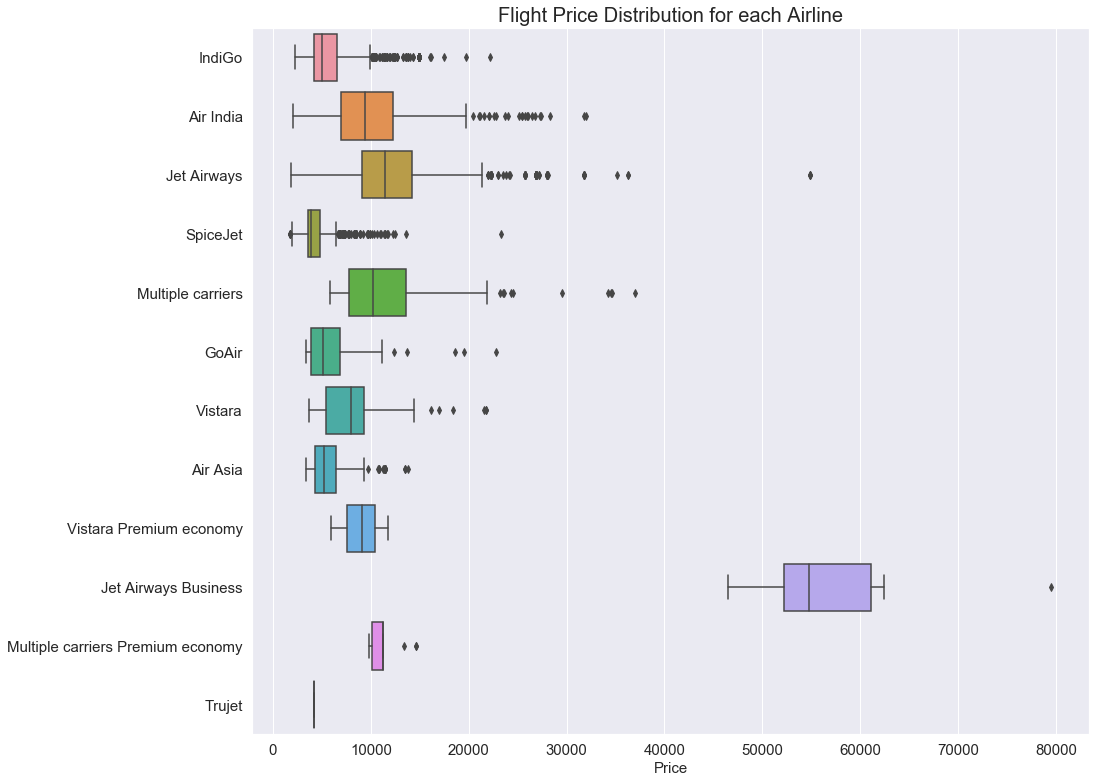

In [8]:
plt.figure(figsize = (15,13))
sb.boxplot(y = 'Airline', x = 'Price', data = ds)
plt.ylabel('')
plt.xlabel('Price', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.title('Flight Price Distribution for each Airline',  fontsize = 20 )
plt.show()

From above plot, we see that Jet Airways Business is the most Expensive flights to board, where its highest price can reach close to ₹80,000, whereas, SpiceJet and Trujet are the cheapest Airlines among the group. 

We can also see that, Jet Airways has one of the largest variations in price, whereas, Trujet has almost no variations in price.

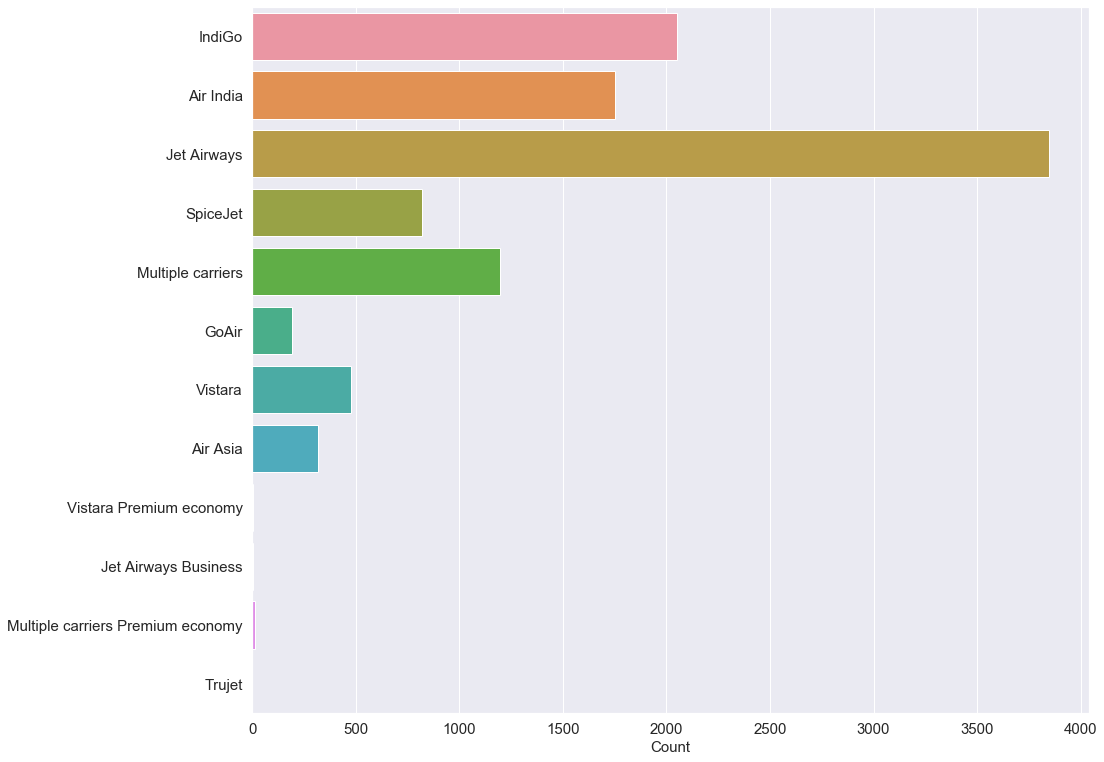

In [9]:
plt.figure(figsize = (15,13))
sb.countplot(y = 'Airline', data = ds)
plt.ylabel('')
plt.xlabel('Count', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.show()

From above barchart, we see that, Jet Airways is most preferred filght for travel, whereas, flights like Vistara Premium economy, Jet Airways Business, Multiple carriers Premium economy and Trujet are least preferred filghts for travel.

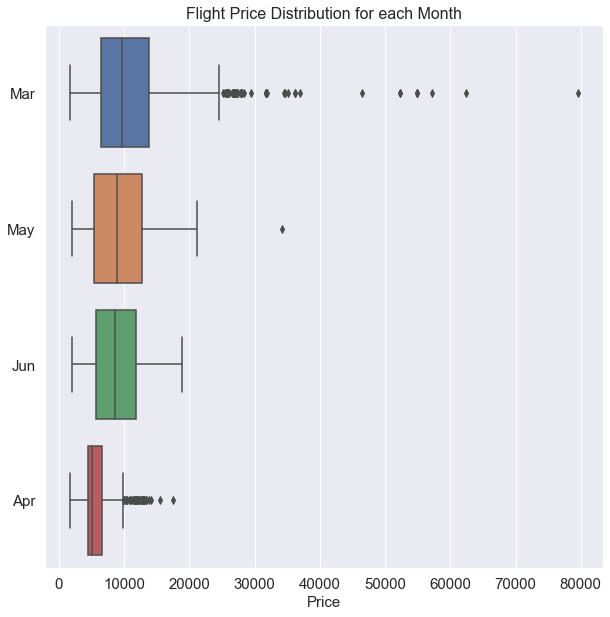

In [10]:
plt.figure(figsize = (10,10))
sb.boxplot(y = 'Date_of_Journey(month)', x = 'Price', data = ds)
plt.ylabel('')
plt.xlabel('Price', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.title('Flight Price Distribution for each Month',  fontsize = 16 )
plt.show()

From above plot, we see that, during March, median flight price is the highest, also it gets close to ₹80,000, also by comparing previous charts, we can infer that, all passengers have  flown with Jet Airways Buissiness during March.

Whereas, Flight prices during April are the lowest.

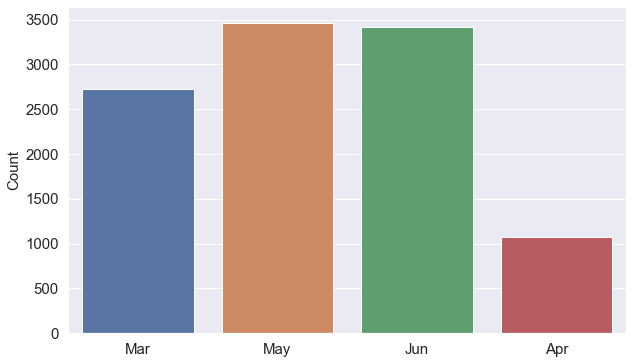

In [11]:
plt.figure(figsize = (10,6))
sb.countplot(x = 'Date_of_Journey(month)', data = ds)
plt.xlabel('')
plt.ylabel('Count', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

From above graph, we see that, most passengers travel through filghts during May and June, whereas, during April, the passengers travels the least through flights.

In [12]:
for col in ds.columns:
    print('unique values of column ' +col+ ' : ', ds[col].value_counts().count())

unique values of column Airline :  12
unique values of column Source :  5
unique values of column Destination :  6
unique values of column Route :  128
unique values of column Dep_Time :  222
unique values of column Arrival_Time :  1343
unique values of column Duration :  368
unique values of column Total_Stops :  5
unique values of column Additional_Info :  10
unique values of column Price :  1870
unique values of column Date_of_Journey(month) :  4
unique values of column Date_of_Journey(weekday) :  7


In [13]:
# defining functing, to extract time in minutes from string data.
def to_minutes(s):
    
    if s[-1] == 'h':
        s = s.replace('h','')
        hours = int(s)
        minutes = hours*60
        return(minutes)

    else:
        s = s.replace('m','')
        hours = int((s.split('h ')[0]))
        minutes = int((s.split('h ')[-1]))
        hours = hours*60
        minutes = hours+minutes
    return(minutes)  

In [14]:
ds['Duration(minutes)'] = ds['Duration'].apply(to_minutes)

In [15]:
ds

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Journey(month),Date_of_Journey(weekday),Duration(minutes)
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,Mar,SUN,170
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,May,WED,445
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,Jun,SUN,1140
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,May,SUN,325
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,Mar,FRI,285
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107,Apr,TUE,150
10679,Air India,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145,Apr,SAT,155
10680,Jet Airways,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229,Apr,SAT,180
10681,Vistara,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648,Mar,FRI,160


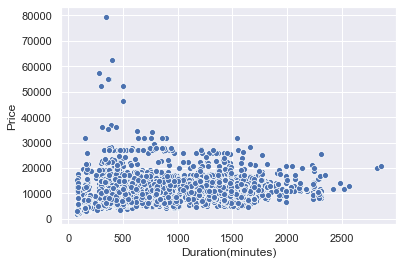

In [16]:
sb.scatterplot(x = 'Duration(minutes)', y =  'Price',  data = ds)

In [17]:
ds['Duration(minutes)'].corr(ds['Price'])

0.5064972164276946

From above scatterplot and correlation, we see that flight duration is not significantly correlated with flight price, and has correlation of 0.5 .

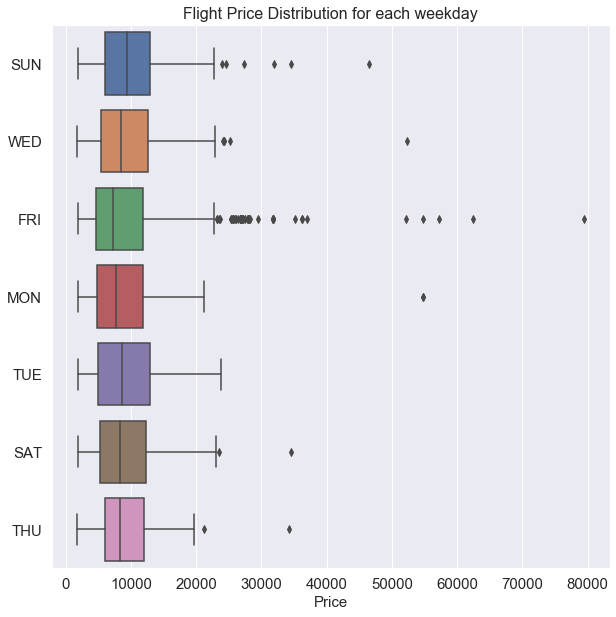

In [18]:
plt.figure(figsize = (10,10))
sb.boxplot(y = 'Date_of_Journey(weekday)', x = 'Price', data = ds)
plt.ylabel('')
plt.xlabel('Price', fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.title('Flight Price Distribution for each weekday',  fontsize = 16 )
plt.show()

From above plot, we se that during fridays, the filght price has most variations.

And during Sundays, we have highest median price of flights, whereas on fridays, we see lowest median flight price, but, during fridays we also see extreme values in flight prices, reaching  close to ₹80,000. 

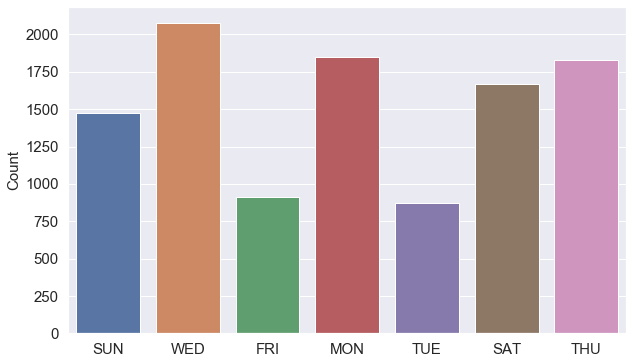

In [19]:
plt.figure(figsize = (10,6))
sb.countplot(x = 'Date_of_Journey(weekday)', data = ds)
plt.xlabel('')
plt.ylabel('Count', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

From above graphs, we see that, the frequency of travelling through flights during Wednesdays are highest, whereas, that of Fridays and Tuesdays are lowest.

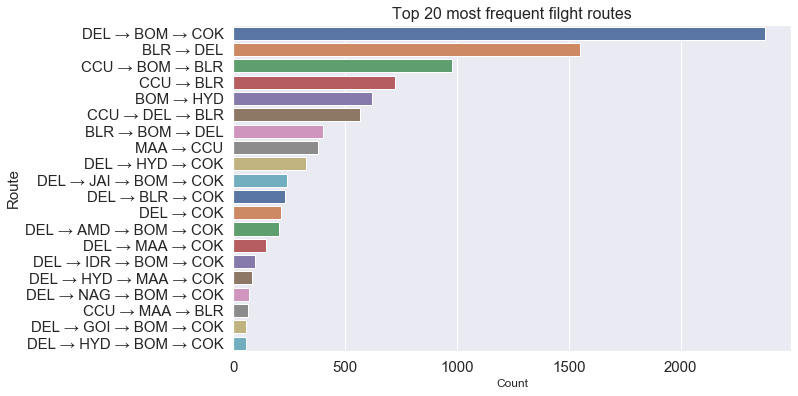

In [20]:
route = pd.DataFrame(ds['Route'].value_counts()[0:20])
plt.figure(figsize = (10,6))
sb.barplot( y = route.index, x =  'Route', data = route, palette = 'deep' )
plt.xlabel('Count')
plt.ylabel('Route', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Top 20 most frequent filght routes', fontsize = 16)
plt.show()

From above plot, we see that passengers fly most frequently through Delhi to Bombay to Cochin route.

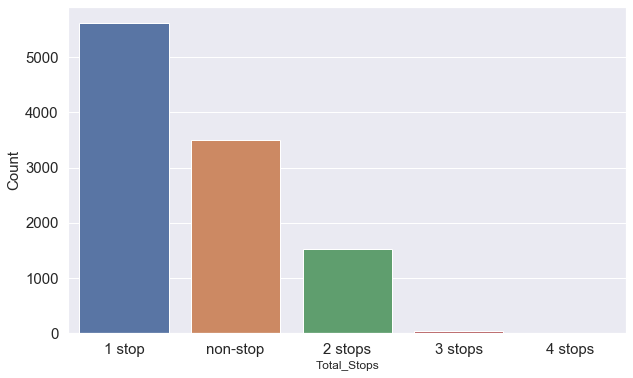

In [21]:
plt.figure(figsize = (10,6))
sb.barplot( y = ds.Total_Stops.value_counts(), x =  ds.Total_Stops.value_counts().index)
plt.xlabel('Total_Stops')
plt.ylabel('Count', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('', fontsize = 16)
plt.show()

Flights travels having less number of stops are more common.

In [22]:
ds.Total_Stops.value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

From above series, we have only 1 flights having 4 stops, so we shall group it with flights having 3 stops.

In [23]:
ds['Total_Stops'].replace('4 stops','3 stops', inplace = True)

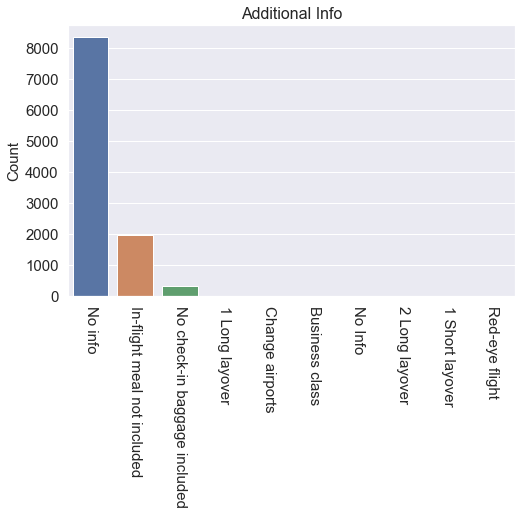

In [24]:
plt.figure(figsize = (8,5))
sb.barplot( y = ds.Additional_Info.value_counts(), x =  ds.Additional_Info.value_counts().index)
plt.xlabel('')
plt.ylabel('Count', fontsize = 15)
plt.xticks(fontsize = 15, rotation = -90)
plt.yticks(fontsize = 15)
plt.title('Additional Info', fontsize = 16)
plt.show()

Here, most of the flights don't have any additional information. 

In [25]:
ds.Additional_Info.value_counts()

No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
2 Long layover                     1
1 Short layover                    1
Red-eye flight                     1
Name: Additional_Info, dtype: int64

From above plot, we see most of the categories after third row are almost nil or having very less counts, to which we shall group together. Also, there is two same categories like 'No info' and 'No Info',to which we shall group together as well.

In [26]:
# grouping categries within 'Additional_Info'.
ds['Additional_Info'].replace('No Info', 'No info', inplace = True)
ds['Additional_Info'].replace('2 Long layover', '1 Long layover', inplace = True)
ds['Additional_Info'].replace('Red-eye flight', '1 Long layover', inplace = True)
ds['Additional_Info'].replace('1 Short layover', 'In-flight meal not included', inplace = True)

From above distplot, we see that duration of flights have right skewed distribution, in which most of the filght takes  less amount of time to reach its destination.

In [27]:
ds

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date_of_Journey(month),Date_of_Journey(weekday),Duration(minutes)
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,Mar,SUN,170
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,May,WED,445
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,Jun,SUN,1140
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,May,SUN,325
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,Mar,FRI,285
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107,Apr,TUE,150
10679,Air India,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145,Apr,SAT,155
10680,Jet Airways,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229,Apr,SAT,180
10681,Vistara,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648,Mar,FRI,160


In [28]:
# dropping features that are not useful for modelling.
ds_red = ds.drop(['Dep_Time','Arrival_Time','Duration'],1)

In [29]:
x_train, x_test, y_train, y_test = train_test_split(ds_red.drop('Price',1), ds_red['Price'],
                                                   test_size = 0.3, random_state = 42)

In [30]:
x_train.shape , x_test.shape, y_train.shape, y_test.shape

((7478, 9), (3205, 9), (7478,), (3205,))

In [31]:
x_train_copy = x_train.copy() # copying x_train for transforming test dataset later on.

In [32]:
# target encoding columns. 
for col in x_train.columns:
    if col not in ['Duration(minutes)','Source','Destination']:
        encoder = ce.TargetEncoder()
        x_train[col] = encoder.fit_transform(x_train[col], y_train)
        x_test[col] = encoder.transform(x_test[col])

In [33]:
# minmax-sclaing columns.
for col in x_train.columns:
    if col not in ['Duration(minutes)','Source','Destination']:
        scale = MinMaxScaler()
        x_train[col] = scale.fit_transform(x_train[col].values.reshape(-1,1))
        x_test[col] = scale.transform(x_test[col].values.reshape(-1,1))

In [34]:
# robust scaling.
transformer = RobustScaler().fit(x_train['Duration(minutes)'].values.reshape(-1,1))
x_train['Duration(minutes)'] = transformer.transform(x_train['Duration(minutes)'].values.reshape(-1,1))
x_test['Duration(minutes)'] = transformer.transform(x_test['Duration(minutes)'].values.reshape(-1,1))

In [35]:
# dummy encoding columns.
ohe = ['Source','Destination']

x_train = pd.get_dummies(data = x_train, prefix = ohe, columns = ohe, drop_first = True)
x_test = pd.get_dummies(data = x_test, prefix = ohe, columns = ohe, drop_first = True )

In [36]:
x_train

,Airline,Route,Total_Stops,Additional_Info,Date_of_Journey(month),Date_of_Journey(weekday),Duration(minutes),Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
749,0.137122,0.000000,0.000000,0.110148,0.609315,0.352185,-0.559211,0,0,0,1,0,0,1,0,0
6909,0.122792,0.384492,0.657863,0.110148,1.000000,0.856091,0.085526,0,1,0,0,1,0,0,0,0
2373,0.122792,0.384492,0.657863,0.110148,0.679184,0.000000,0.151316,0,1,0,0,1,0,0,0,0
2442,0.021118,0.375801,0.657863,0.110148,0.679184,0.352185,0.269737,0,0,1,0,0,0,0,0,0
5402,0.100668,0.478242,0.907106,0.110148,0.609315,0.856091,1.177632,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.137122,0.384492,0.657863,0.110148,1.000000,0.689003,0.855263,0,1,0,0,1,0,0,0,0
5191,0.137122,0.414204,0.657863,0.116632,0.679184,0.352185,-0.151316,0,0,1,0,0,0,0,0,0
5390,0.122792,0.384492,0.657863,0.110148,0.679184,0.689003,0.322368,0,1,0,0,1,0,0,0,0
860,0.024706,0.082415,0.000000,0.110148,1.000000,0.856091,-0.460526,0,0,0,0,0,0,0,0,1


In [37]:
# using selectkbest for feature selection
selector = SelectKBest(mutual_info_regression, k = 'all')
selector.fit(x_train, y_train)

SelectKBest(k='all',
            score_func=<function mutual_info_regression at 0x000001F3056E43A8>)

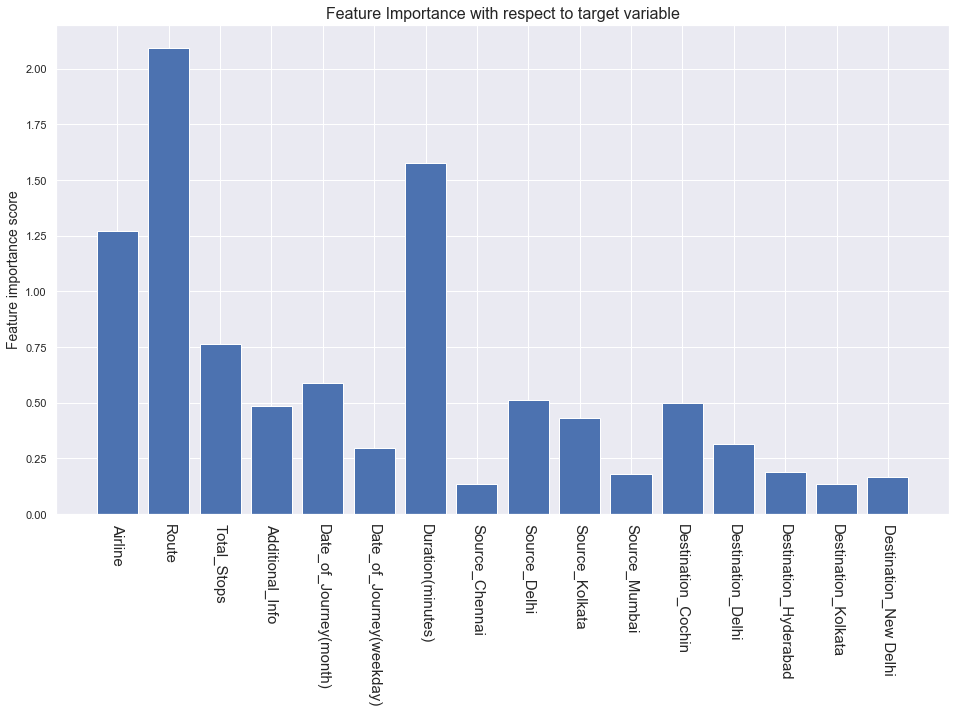

In [38]:
# plotting  the scores
plt.figure(figsize = (16,9))
plt.bar(x_train.columns, selector.scores_)
plt.xticks(rotation = -90, fontsize = 15)
plt.title('Feature Importance with respect to target variable', fontsize = 16)
plt.ylabel('Feature importance score', fontsize = 14)
plt.show()

From above plot, we see that route, duration in minutes and airline plays significant role in flight price predictions. Also, we see all features have a non-zero score, so we shall select all.

In [39]:
k = KFold(n_splits = 10)

model: RandomForestRegressor()
CV score:0.8213384853501207
score_std: 0.04569518071574829
----------
model: LinearRegression(normalize=True)
CV score:0.6453813593106171
score_std: 0.043711378145664885
----------
model: SVR()
CV score:0.08280842373599585
score_std: 0.022253047580171364
----------
model: AdaBoostRegressor()
CV score:0.5752766107961091
score_std: 0.05757420199117198
----------
model: GradientBoostingRegressor()
CV score:0.800511295499881
score_std: 0.04005748861757869
----------
model: KNeighborsRegressor()
CV score:0.6695906714903901
score_std: 0.021268474212664097
----------
model: XGBRegressor(silent=True)
CV score:0.7958608797516581
score_std: 0.040064414962854476
----------
model: Lasso(normalize=True)
CV score:0.6430619017209389
score_std: 0.0396071502684753
----------
model: Ridge(normalize=True)
CV score:0.5839467036786365
score_std: 0.032343309117261076
----------
model: ElasticNet()
CV score:0.320828949807777
score_std: 0.03559501695740174
----------
model: Deci

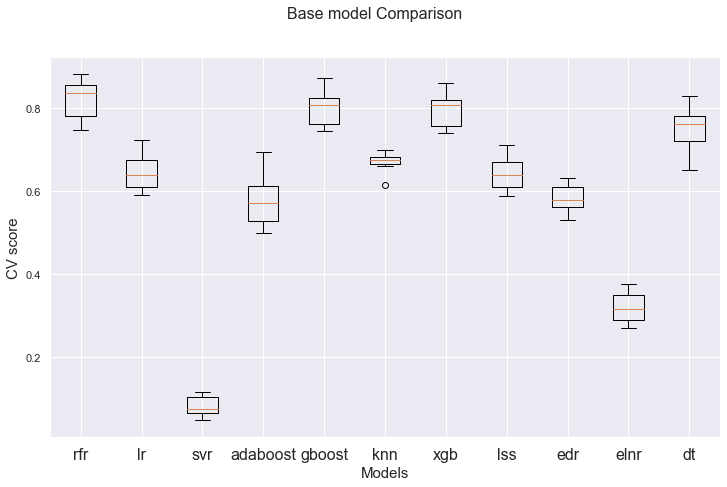

In [40]:
# inilializing different models
rfr = RandomForestRegressor()
svr = SVR()
lr = LinearRegression(normalize = True)
adaboost =  AdaBoostRegressor()
gboost = GradientBoostingRegressor()
knn = KNeighborsRegressor()
xgb = xgboost.XGBRegressor(silent = True)
lss = Lasso(normalize = True)
rdr = Ridge(normalize = True)
elnr = ElasticNet()
dt = DecisionTreeRegressor()

models = [rfr, lr, svr, adaboost, gboost, knn, xgb, lss, rdr, elnr, dt]

scores = []
for model in models:
    
    score = cross_val_score(model, x_train, y_train, cv = k, scoring = 'r2', n_jobs = -1 )
    mean_score = score.mean()
    std_score = score.std()
    
    print('model: {}'.format(model))
    print('CV score:{}'.format(mean_score))
    print('score_std:',std_score)
    print('----------')
    scores.append(score)
    
fig = plt.figure()
fig.suptitle('Base model Comparison', fontsize = 16)
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(['rfr', 'lr','svr', 'adaboost', 'gboost', 'knn', 'xgb','lss','edr','elnr','dt'],
                  fontsize = 16)
plt.xlabel('Models', fontsize = 15)
plt.ylabel('CV score', fontsize = 15)
fig.set_size_inches(12,7)
plt.show() 

From above boxplots, based of cross-val-scores, we shall select models like rf, gboost, xgb and dt for further tuning.

### Hyper-parameter tuning

In [41]:
param_gboost =  dict(
    learning_rate = [0.01,0.03,0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.5],
    max_depth = [2,3,4, 5, 6,7,8,9,10],
    n_estimators = [100, 150, 200,250,300],
    min_samples_split = [1,2,3], random_state = [37,38,39,40,41,42,43,44,45],
    alpha = [0.05,0.1,0.5,0.75,1,1.75,2])

param_rfr = dict(n_estimators = [10,15,20,25,30,45,50], criterion = ['mse', 'mae'],
                max_depth = [2,3,4,5,6,7,None],min_samples_split = [1,2,3,4,5],
                min_samples_leaf = [1,2,3,4], random_state = [37,38,39,40,41,42,43,44,45])

  
param_xgb = dict( learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
     max_depth = [ 3, 4, 5, 6, 8, 10, 12, 15],
     min_child_weight = [ 1, 3, 5, 7 ],
     gamma = [0.0, 0.1, 0.2 , 0.3, 0.4 ],
     colsample_bytree = [ 0.3, 0.4, 0.5 , 0.7 ],
     alpha = [0.05,0.1,0.5,0.75,1,1.75,2]
     )

param_dt = dict(splitter = ['best', 'random'], criterion = ['mse', 'friedman_mse', 'mae'],
                max_depth = [3,4,5,6,7,8,None],min_samples_split = [2,3,4],
                min_samples_leaf = [1,2,3], random_state = [40,41,42,43,44]
                )

In [42]:
model_param_list = [(gboost,param_gboost),(rfr,param_rfr), (xgb,param_xgb), (dt,param_dt)]

In [43]:
%%time
best_estimator_list = []
for model, param in model_param_list:
    
    r_rearch = RandomizedSearchCV(model, param, cv = k, n_jobs = -1, scoring = 'r2',
                                 random_state = 42)
    r_rearch.fit(x_train, y_train.values.ravel())
    best_cvscore = r_rearch.best_score_
    best_param = r_rearch.best_params_
    best_estimator = r_rearch.best_estimator_
    best_estimator_list.append(best_estimator)
    
    print('model:',model)
    print('best_cvscore:',best_cvscore)
    print('best_param:', best_param)
    print('\n')
    
print('best_estimators:',best_estimator_list)

model: GradientBoostingRegressor()
best_cvscore: 0.8315869017316884
best_param: {'random_state': 43, 'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 7, 'learning_rate': 0.1, 'alpha': 0.75}


model: RandomForestRegressor()
best_cvscore: 0.8155477408371633
best_param: {'random_state': 39, 'n_estimators': 25, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'mae'}


model: XGBRegressor(silent=True)
best_cvscore: 0.8415744254304386
best_param: {'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.5, 'alpha': 0.1}


model: DecisionTreeRegressor()
best_cvscore: 0.7898627538629077
best_param: {'splitter': 'best', 'random_state': 43, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 8, 'criterion': 'friedman_mse'}


best_estimators: [GradientBoostingRegressor(alpha=0.75, max_depth=7, n_estimators=200,
                          random_state=43), RandomForestRegressor(criterion='mae', min_samples_leaf=

### Testing

In [44]:
# testing for train data
print('****TRAIN RESULTS****')
print('\n')

for model in best_estimator_list:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    score = r2_score(y_train, y_pred)
    print('model',model)
    print('accuracy (r2_score):',  round(score*100,2),'%')
    print('root_mean_squared_error:',mean_squared_error(y_train, y_pred, squared = False))
    print('-------------------------------------------')

****TRAIN RESULTS****


model GradientBoostingRegressor(alpha=0.75, max_depth=7, n_estimators=200,
                          random_state=43)
accuracy (r2_score): 94.53 %
root_mean_squared_error: 1089.4506305074904
-------------------------------------------
model RandomForestRegressor(criterion='mae', min_samples_leaf=2, min_samples_split=3,
                      n_estimators=25, random_state=39)
accuracy (r2_score): 90.94 %
root_mean_squared_error: 1402.8665075124338
-------------------------------------------
model XGBRegressor(alpha=0.1, colsample_bytree=0.5, gamma=0.2, learning_rate=0.2,
             max_depth=12, min_child_weight=3, silent=True)
accuracy (r2_score): 94.41 %
root_mean_squared_error: 1101.9145249207788
-------------------------------------------
model DecisionTreeRegressor(criterion='friedman_mse', max_depth=8, min_samples_leaf=2,
                      min_samples_split=3, random_state=43)
accuracy (r2_score): 83.58 %
root_mean_squared_error: 1888.1066453687279
---

In [45]:
#testing for test data
print('****TEST RESULTS****')
print('\n')

for model in best_estimator_list:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    score = r2_score(y_test, y_pred)
    print('model',model)
    print('accuracy (r2_score):',  round(score*100,2),'%')
    print('root_mean_squared_error:',mean_squared_error(y_test, y_pred, squared = False))
    print('-------------------------------------------')

****TEST RESULTS****


model GradientBoostingRegressor(alpha=0.75, max_depth=7, n_estimators=200,
                          random_state=43)
accuracy (r2_score): 82.24 %
root_mean_squared_error: 1894.175411687074
-------------------------------------------
model RandomForestRegressor(criterion='mae', min_samples_leaf=2, min_samples_split=3,
                      n_estimators=25, random_state=39)
accuracy (r2_score): 84.65 %
root_mean_squared_error: 1760.8789020146123
-------------------------------------------
model XGBRegressor(alpha=0.1, colsample_bytree=0.5, gamma=0.2, learning_rate=0.2,
             max_depth=12, min_child_weight=3, silent=True)
accuracy (r2_score): 84.26 %
root_mean_squared_error: 1783.0377645630035
-------------------------------------------
model DecisionTreeRegressor(criterion='friedman_mse', max_depth=8, min_samples_leaf=2,
                      min_samples_split=3, random_state=43)
accuracy (r2_score): 79.28 %
root_mean_squared_error: 2045.8748341989299
-----

From above train and test results, RandomForestRegressor scored best on r2 score and has least root mean squared erroe (rmse), compared to other models, hence, we shall select our final model as RandomForestRegressor. 

In [46]:
# selecting best model as RandomForestRegressor.
selected_model = RandomForestRegressor(criterion='mae', min_samples_leaf=2, min_samples_split=3,
                      n_estimators=25, random_state=39)

selected_model.fit(x_train, y_train)

y_pred = selected_model.predict(x_test)

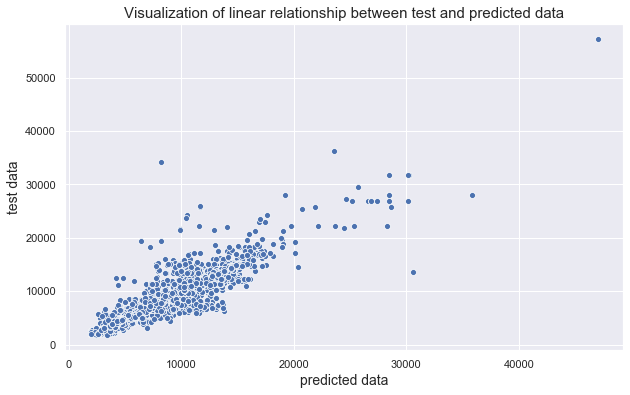

In [47]:
plt.figure(figsize = (10,6))
sb.scatterplot(y_pred,y_test )
plt.xlabel('predicted data', fontsize = 14)
plt.ylabel('test data',  fontsize = 14)
plt.title('Visualization of linear relationship between test and predicted data',fontsize = 15 )
plt.show()

From above scatterplot, we can visualize a linear relationship between predicted and test data, which is one of the standard for regression model evaluation.  

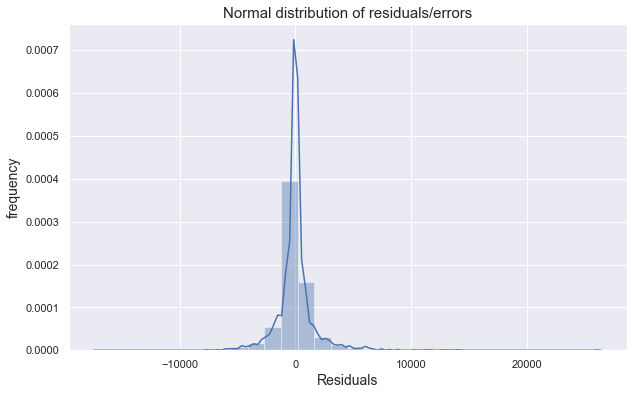

In [48]:
plt.figure(figsize = (10,6))
sb.distplot((y_test-y_pred), bins = 30)
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('frequency',  fontsize = 14)
plt.title('Normal distribution of residuals/errors',fontsize = 15 )
plt.show()

From above plots, we can see that out residuals are alomost normally distributed around the mean, that is approximately zero, which is a good sign for a regression model.

In [49]:
test_df = pd.DataFrame({'Actual price':y_test.values,'Predicted price':y_pred})

In [50]:
test_df.to_csv('flight_price_pred.csv', index = False)
print('Predicted result stored sucessfully.')

Predicted result stored sucessfully.


In [51]:
# Saving the final model as RandomForestRegressor.
import joblib

joblib.dump(selected_model, 'flight_price_pred.obj')
print('Model successfully saved.')

Model successfully saved.


###  Data-preprocessing of Test dataset for prediction.

In [52]:
test = pd.read_excel('Test_set.xlsx')
test

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info
...,...,...,...,...,...,...,...,...,...,...
2666,Air India,6/06/2019,Kolkata,Banglore,CCU → DEL → BLR,20:30,20:25 07 Jun,23h 55m,1 stop,No info
2667,IndiGo,27/03/2019,Kolkata,Banglore,CCU → BLR,14:20,16:55,2h 35m,non-stop,No info
2668,Jet Airways,6/03/2019,Delhi,Cochin,DEL → BOM → COK,21:50,04:25 07 Mar,6h 35m,1 stop,No info
2669,Air India,6/03/2019,Delhi,Cochin,DEL → BOM → COK,04:00,19:15,15h 15m,1 stop,No info


In [53]:
test.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

There are no missing values to impute.

In [54]:
to_date_time('Date_of_Journey', test)

# creating column for duration in minutes.
test['Duration(minutes)'] = test['Duration'].apply(to_minutes)

# grouping  '4 stops' category within '3 stops'.
test['Total_Stops'].replace('4 stops','3 stops', inplace = True)

# grouping categries within 'Additional_Info'.
test['Additional_Info'].replace('No Info', 'No info', inplace = True)
test['Additional_Info'].replace('2 Long layover', '1 Long layover', inplace = True)
test['Additional_Info'].replace('Red-eye flight', '1 Long layover', inplace = True)
test['Additional_Info'].replace('1 Short layover', 'In-flight meal not included', inplace = True)

# dropping features that are not useful for modelling.
test = test.drop(['Dep_Time','Arrival_Time','Duration'],1)

In [55]:
# target encoding columns in test dataset. 
for col in x_train_copy.columns:
    if col not in ['Duration(minutes)','Source','Destination']:
        encoder = ce.TargetEncoder()
        x_train_copy[col] = encoder.fit_transform(x_train_copy[col], y_train)
        test[col] = encoder.transform(test[col])

In [56]:
# minmax-sclaing columns in test dataset.
for col in x_train_copy.columns:
    if col not in ['Duration(minutes)','Source','Destination']:
        scale = MinMaxScaler()
        x_train_copy[col] = scale.fit_transform(x_train_copy[col].values.reshape(-1,1))
        test[col] = scale.transform(test[col].values.reshape(-1,1))

In [57]:
# robust scaling in test dataset.
transformer = RobustScaler().fit(x_train_copy['Duration(minutes)'].values.reshape(-1,1))
x_train_copy['Duration(minutes)'] = transformer.transform(x_train['Duration(minutes)'].values.reshape(-1,1))
test['Duration(minutes)'] = transformer.transform(test['Duration(minutes)'].values.reshape(-1,1))

In [58]:
# dummy encoding columns in test dataset.
ohe = ['Source','Destination']
test = pd.get_dummies(data = test, prefix = ohe, columns = ohe, drop_first = True )

In [59]:
test

,Airline,Route,Total_Stops,Additional_Info,Date_of_Journey(month),Date_of_Journey(weekday),Duration(minutes),Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0.137122,0.384492,0.657863,0.110148,0.609315,0.352185,0.184211,0,1,0,0,1,0,0,0,0
1,0.024706,0.071655,0.657863,0.110148,0.669800,0.352185,-0.361842,0,0,1,0,0,0,0,0,0
2,0.137122,0.384492,0.657863,0.116632,0.679184,0.314966,1.197368,0,1,0,0,1,0,0,0,0
3,0.122792,0.384492,0.657863,0.110148,0.679184,0.314966,0.348684,0,1,0,0,1,0,0,0,0
4,0.021118,0.082415,0.000000,0.110148,0.609315,0.000000,-0.453947,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,0.100668,0.375801,0.657863,0.110148,0.609315,0.352185,1.210526,0,0,1,0,0,0,0,0,0
2667,0.024706,0.030861,0.000000,0.110148,1.000000,0.689003,-0.473684,0,0,1,0,0,0,0,0,0
2668,0.137122,0.384492,0.657863,0.110148,0.609315,0.000000,-0.157895,0,1,0,0,1,0,0,0,0
2669,0.100668,0.384492,0.657863,0.110148,0.609315,0.000000,0.526316,0,1,0,0,1,0,0,0,0


In [60]:
# loading  object file of the model for predicting test dataset.
model = joblib.load('flight_price_pred.obj')

In [61]:
y_test_pred = model.predict(test)

In [62]:
test_2 = pd.DataFrame({'Pedicted price':y_test_pred})

In [63]:
test_2.to_csv('flight_price_test_pred.csv', index = False)
print('Predicted result of test data  stored sucessfully.')

Predicted result of test data  stored sucessfully.
